# Generate EKF C-code from Dynamic System Model

In [1]:
# Generate and Compile C Code
%run generate_ekf.py

import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)
importlib.reload(subprocess)

# Compile C code and create library

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Remove old library
subprocess.call('rm -f *.so', shell=True, cwd=path)
subprocess.call('rm -f *.o', shell=True, cwd=path)
# Compile object files
subprocess.call('gcc -fPIC -c *.c common/*.c -Icommon', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
# subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
lib = ctypes.CDLL(lib_path)

# define argument types 
lib.ekf_set_Q.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R_mocap.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R_vbody.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_X.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_P_diag.argtypes = [ctypes.POINTER(ctypes.c_float)]

lib.ekf_get_X.restype = ctypes.POINTER(ctypes.c_float)
lib.ekf_get_P.restype = ctypes.POINTER(ctypes.c_float)

lib.ekf_predict.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_float]
lib.ekf_update_mocap.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_update_vbody.argtypes = [ctypes.POINTER(ctypes.c_float)]

ekf_use_quat = ctypes.c_bool.in_dll(lib, "ekf_use_quat")
ekf_use_quat.value = True

PREDICTION:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE


# Test C code

In [2]:
import matplotlib.pyplot as plt
from analyze import *
from scipy import signal

#data = np.load('ekf_data_6may_8ms_delay.npz')
data1 = load_flight_data('flight_data/Okt12_Orin_drone_TT.csv')
data2 = load_flight_data('flight_data/Okt12_Orin_drone_TT2.csv')
data3 = load_flight_data('flight_data/Okt12_Orin_drone_NN.csv')
data4 = load_flight_data('flight_data/Okt12_Orin_drone_NN2.csv')
#data = trim_nn_active(data)
data1 = trim_time(data1,30, 52)
data2 = trim_time(data2,12, 35)
data3 = trim_time(data3,6, 13.5)
data4 = trim_time(data4,6, 13.5)



Loading flight_data/Okt12_Orin_drone_TT.csv
Logging frequency: 503.54147435166954
Loading flight_data/Okt12_Orin_drone_TT2.csv
Logging frequency: 503.50492116090436
Loading flight_data/Okt12_Orin_drone_NN.csv
Logging frequency: 503.377646378566
Loading flight_data/Okt12_Orin_drone_NN2.csv
Logging frequency: 503.3947213342951


In [99]:
data = data1
k0, k1, k2, k3, k4, k5, k6, k7, k8, k_y, k_omega, k_h, k_z = fit_thrust_drag_model_extended(data)
print(f'k0: {k0}, k1: {k1}, k2: {k2}, k3: {k3}, k4: {k4}, k5: {k5}, k6: {k6}, k7: {k7}, k8: {k8}, k_y: {k_y}, k_omega: {k_omega}, k_h: {k_h}, k_z: {k_z} ')

k_x, k_y, k_omega = fit_thrust_drag_model(data)
print(f'k_x: {k_x}, k_y: {k_y}, k_omega: {k_omega}')
dr = data['dr']
# derivative of gyro
# 

data = 0

fitting thrust and drag model
k_x: -5.475475158787861e-05, k_y: -4.0602951596347126e-05, k_omega: -1.585600252700097e-06, k_h: -0.02571975534094661, k_z: -7.682201976344573e-05 
fitting thrust and drag model
k_x: -5.475475158787861e-05, k_y: -4.0602951596347126e-05, k_omega: -1.602131253678481e-06


In [100]:
data = data1

# optitrack frequency    drag
opti_updates =  [i for i in range(1,len(data['t'])) if ((data['x_opti'][i]!=data['x_opti'][i-1]) | (data['y_opti'][i]!=data['y_opti'][i-1]) | (data['z_opti'][i]!=data['z_opti'][i-1]))]

opti_freq = 1/np.mean(np.diff(data['t'][opti_updates]))
print('optitrack frequency:',opti_freq,'Hz')

U_data = np.array([
    data['ax'], data['ay'], data['az'], data['p'], data['q'], data['r']
]).T

# EKF MEASUREMENT MOCAP: Z = [x, y, z, qw, qx, qy, qz] (Optitrack)
Z_data_mocap = np.array([
    data['x_opti'], data['y_opti'], data['z_opti'], data['qw_opti'], data['qx_opti'], data['qy_opti'], data['qz_opti']
]).T
# EKF MEASUREMENT VBODY Z = [vbx, vby]
Z_data_vbody = np.array([data['vbx'], data['vby']]).T
# Z_data_vbody = np.array([data['vbx'], data['vby']]).T

t = data['t']



optitrack frequency: 20.751708994451995 Hz


In [89]:
animate_data_multiple(data)

In [ ]:
# # equation from https://arxiv.org/pdf/2409.01080
# # ar = omega_dot x r + omega x (omega x r)
# from sympy import symbols, Matrix
# rx, ry, rz = symbols('rx ry rz')
# p, q, r = symbols('p q r')
# dp, dq, dr = symbols('dp dq dr')
# omega = Matrix([p, q, r])
# omega_dot = Matrix([dp, dq, dr])
# r = Matrix([rx, ry, rz])
# rhs = omega_dot.cross(r) + omega.cross(omega.cross(r))
# for ri in rhs:
#     print(ri)

In [102]:
# fit_thrust_drag_model(data)

# r_y = 18 - 5.35
# r_x = 18 - 13.89


# we have a drag model for ax and ay
# ax = k_x * vbx *(omega[0] + omega[1] + omega[2] + omega[3])
# ay = k_y * vby *(omega[0] + omega[1] + omega[2] + omega[3])
# we can find k_x and k_y with linear regression
ax = data['ax']-data['ekf_acc_b_x']
ay = data['ay']-data['ekf_acc_b_y']
vbx = data['vbx']
vby = data['vby']
omega0, omega1, omega2, omega3 = data['omega[0]'], data['omega[1]'], data['omega[2]'], data['omega[3]']
p = data['p']
q = data['q']
r = data['r'] 

# derivatives can be read directly from alpha 0-2
dp = data['dp']
dq = data['dq']
dr = data['dr']
# derivative of gyro
# dp = np.gradient(data['p'], data['t'])
#dq = np.gradient(data['q'], data['t'])
#dr = np.gradient(data['r'], data['t'])
# low pass butterworth filtfilt
# import scipy.signal as signal
# b, a = signal.butter(2, 0.02)
# dp = signal.filtfilt(b, a, dp)
# dq = signal.filtfilt(b, a, dq)
# dr = signal.filtfilt(b, a, dr)

# new regression model
# ax = ax_drag + ax_r
# ax_r = dq*rz - dr*ry + q*(p*ry - q*rx) - r*(-p*rz + r*rx)
# ax_r = rx*(-q**2 - r**2) + ry*(p*q - dr) + rz*(p*r + dq)
X = np.stack([
    vbx*(omega0 + omega1 + omega2 + omega3), # drag model
    -q**2-r**2, # rx
    p*q-dr, # ry
    p*r+dq # rz
])
Y = ax
k_x, rx, ry, rz = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_x, rx, ry, rz:', k_x, rx, ry, rz)
ax_est_gyro_effect = A@X

gravity_body = np.stack([
            Rmat(phi, theta, psi).T@[0, 0, 9.81]
            for phi, theta, psi
            in zip(data['phi'],data['theta'],data['psi'])
        ])

dt = 0.002
dV_cg_x = np.diff(data['vbx'])
dV_cg_y = np.diff(data['vby'])

# Pad the acceleration arrays to match the original length
dV_cg_x = np.pad(dV_cg_x, (1, 0), mode='edge')
dV_cg_y = np.pad(dV_cg_y, (1, 0), mode='edge')

dV_drag_x_meas = ax * dt
dV_drag_y_meas = ay * dt

# Apply a low-pass filter
fs = 1 / np.mean(dt)  # Estimate sampling frequency
fc = 10  # Cut-off frequency of 10 Hz (adjust as needed)
w = fc / (fs / 2)  # Normalize the frequency
b, a = signal.butter(2, w, 'low')

ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)

dV_gravity_body = gravity_body * dt

dV_cg_x = signal.filtfilt(b, a, dV_cg_x)
dV_cg_y = signal.filtfilt(b, a, dV_cg_y)

dV_drag_x_calculated = dV_cg_x - dV_gravity_body[:,0]
dV_drag_y_calculated = dV_cg_y - dV_gravity_body[:,1]

print(dV_cg_x)

dV_drag_x_calculated = signal.filtfilt(b, a, dV_drag_x_calculated)
dV_drag_y_calculated = signal.filtfilt(b, a, dV_drag_y_calculated)

#dV_drag_x_calculated = signal.filtfilt(b, a, dV_drag_x)
#dV_drag_y_calculated = signal.filtfilt(b, a, dV_drag_y)

dV_drag_x_meas = signal.filtfilt(b, a, dV_drag_x_meas)
dV_drag_y_meas = signal.filtfilt(b, a, dV_drag_y_meas)



# new model
X = np.stack([vbx*(omega0 + omega1 + omega2 + omega3), q, r])
Y = ax
k_x_est, k_xq_est, k_xr_est, = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_x_est, k_xq_est, k_xr_est:', k_x_est, k_xq_est, k_xr_est)
ax_est = A@X

# old
X = np.stack([vbx*(omega0 + omega1 + omega2 + omega3)])
Y = ax
k_x_old, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_x_old:', k_x_old)
ax_est_old = A@X

# new model
X = np.stack([vby*(omega0 + omega1 + omega2 + omega3), p, r])
Y = ay
k_y_est, k_yp_est, k_yr_est, = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_y_est, k_yp_est, k_yr_est:', k_y_est, k_yp_est, k_yr_est)
ay_est = A@X

# old
X = np.stack([vby*(omega0 + omega1 + omega2 + omega3)])
Y = ay
k_y_old, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
print('k_y_old:', k_y_old)
ay_est_old = A@X

# simple
X = np.stack([vbx])
Y = ax
k_x_simple, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
ax_est_simple = k_x_simple*vbx

X = np.stack([vby])
Y = ay
k_y_simple, = A= np.linalg.lstsq(X.T, Y, rcond=None)[0]
ay_est_simple = k_y_simple*vby

#az
# 2nd thrust model for ref
X = np.stack([
    data['omega[0]']**2 + data['omega[1]']**2 + data['omega[2]']**2 + data['omega[3]']**2,
    data['vbz']*(data['omega[0]']+data['omega[1]']+data['omega[2]']+data['omega[3]'])
])
kw, kz = A = np.linalg.lstsq(X.T, Y, rcond=None)[0]


plt.plot(data['t'], ax_filt, label='ax')
plt.plot(data['t'], ax_est, label='ax_est')
# plt.plot(data['t'], ax_est_old, label='ax_est_old')
plt.plot(data['t'], ax_est_gyro_effect, label='ax_est_gyro_effect')
plt.plot(data['t'], ax_est_simple, label='ax_est_simple')
plt.plot(data['t'], dV_drag_x_calculated, label='dV_drag_x')
plt.legend()
plt.show()

plt.plot(data['t'], ay, label='ay')
plt.plot(data['t'], ay_est, label='ay_est')
plt.plot(data['t'], ay_est_old, label='ay_est_old')
plt.plot(data['t'], dV_drag_y_calculated, label='dV_drag_y')
plt.legend()


plt.show()

# new plot for dV_drag_x and dV_drag_y
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#ax1.plot(data['t'], dV_drag_x, label='dV_drag_x')
ax1.plot(data['t'], dV_drag_x_calculated, label='dV_drag_x_calculated')
ax1.plot(data['t'], dV_cg_x, label='dV_cg_x ')
ax1.plot(data['t'], dV_gravity_body[:,0], label='dV_gravity_body x')
ax1.plot(data['t'], dV_drag_x_meas, label='dV_drag_x_meas (filtered)')

#ax1.plot(data['t'], ax, label='ax')
#ax2.plot(data['t'], dV_drag_y, label='dV_drag_y')
ax2.plot(data['t'], dV_drag_y_calculated, label='dV_drag_y_calculated')
ax2.plot(data['t'], dV_cg_y, label='dV_cg_y (filtered)')
ax2.plot(data['t'], dV_gravity_body[:,1], label='dV_gravity_body y')
ax2.plot(data['t'], dV_drag_y_meas, label='dV_drag_y_meas (filtered)')
#ax2.plot(data['t'], ay, label='ay')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()


k_x, rx, ry, rz: -5.360825314918224e-05 0.010795204107810407 0.0014613482368215725 -0.009469647072227699
[ 0.00131037  0.00108769  0.00088538 ... -0.00813513 -0.00746828
 -0.0068387 ]
k_x_est, k_xq_est, k_xr_est: -5.439847586919627e-05 0.04138011331796706 -0.044043871825509215
k_x_old: -5.475475158787861e-05
k_y_est, k_yp_est, k_yr_est: -6.889649035193112e-05 4.861477329731745e-05 0.13408466949279033
k_y_old: -4.0602951596347126e-05


In [ ]:
"""
This code tries to estimate the velocity in X and Y using the accelerations and a drag model
"""


# # k_x = -4.41e-5
# # k_y = -5.64e-5

# k_x_quadratic = 0.1

# wsum = data['omega[0]']+data['omega[1]']+data['omega[2]']+data['omega[3]']
# # ax = k_x*wsum*vbx --> vbx = ax/(k_x*wsum)
# # ay = k_y*wsum*vby --> vby = ay/(k_y*wsum)
# vbx_estimate = (data['ax']-data['ekf_acc_b_x'])/(k_x*wsum)
# vby_estimate = (data['ay']-data['ekf_acc_b_y'])/(k_y*wsum)

# vbx_estimate = (data['ax']-data['ekf_acc_b_x'])/(k_x*wsum)
# vby_estimate = (data['ay']-data['ekf_acc_b_y'])/(k_y*wsum)

# data['vbx_estimate'] = vbx_estimate
# data['vby_estimate'] = vby_estimate

# # apply a small filter on ax and ay
# data['ax_filt'] = signal.filtfilt(b, a, data['ax'])
# data['ay_filt'] = signal.filtfilt(b, a, data['ay'])


# vbx_est_filt = signal.filtfilt(b, a, vbx_estimate)
# vby_est_filt = signal.filtfilt(b, a, vby_estimate)

# # # new equation
# # vbx_estimate_new = (data['ax']- k_xq_est*q - k_xr_est*r)/(k_x_est*wsum)
# # vby_estimate_new = (data['ay']- k_yp_est*p - k_yr_est*r)/(k_y_est*wsum)
# # data['vbx_estimate_new'] = vbx_estimate_new
# # data['vby_estimate_new'] = vby_estimate_new
# # vbx_est_new_filt = signal.filtfilt(b, a, vbx_estimate_new)
# # vby_est_new_filt = signal.filtfilt(b, a, vby_estimate_new)

# # ax = vbx*k_x*wsum + vbx**2 * 

# vbx_estimate_proto = (data['ax']- k_x*data['dq'] - k_x*data['dr'])/(k_x*wsum)
# vby_estimate_proto = (data['ay']- k_y*data['dp'] - k_y*data['dr'])/(k_y*wsum)


# # Compute estimates only when conditions are met
# #vbx_estimate_proto = np.where(data['ax_filt'] < -3.5, data['ax_filt'] / (k_x * wsum), np.nan)
# #vby_estimate_proto = np.where(data['ay_filt'] > 1,  data['ay_filt'] / (k_y * wsum), np.nan)

# vbx_estimate_proto = signal.filtfilt(b, a, vbx_estimate_proto)
# vby_estimate_proto = signal.filtfilt(b, a, vby_estimate_proto)

# data['vbx_estimate_proto'] = vbx_estimate_proto
# data['vby_estimate_proto'] = vby_estimate_proto

# #filtfilt



In [105]:
print(' k_x:', k_x, '\n',
      'k_y:', k_y, '\n',
      '\n',
      'k_omega:', k_omega, '\n',
      'k_h:', k_h, '\n',
      'k_z:', k_z, '\n',)


# Thrust model
a_thrust = k_omega * (data['omega[0]']**2 + data['omega[1]']**2 + data['omega[2]']**2 + data['omega[3]']**2)
a_z_h = k_h * (data['vbx']**2 + data['vby']**2)
a_z_spoed = k_z * data['vbz'] * (data['omega[0]'] + data['omega[1]'] + data['omega[2]'] + data['omega[3]'])
#z2_drag = k_z2 * abs(data['vbz']) * abs(data['vbz'])*5


# a_thrust = k_omega*1.0 * (data['omega[0]']**2 + data['omega[1]']**2 + data['omega[2]']**2 + data['omega[3]']**2)
# a_z_h = k_h *  (data['vbx']**2 + data['vby']**2)
# a_z_spoed = k_z * data['vbz'] * (data['omega[0]'] + data['omega[1]'] + data['omega[2]'] + data['omega[3]'])

# Calculate average RPM squared
rpm_squared = (data['omega[0]']**2 + data['omega[1]']**2 + data['omega[2]']**2 + data['omega[3]']**2) / 4
k_extra_est = k_omega * rpm_squared / data['vbz']
a_thrust_total = a_thrust  + a_z_spoed  + a_z_h # + z2_drag

# Calculate the error between az and a_thrust
az_error = data['az'] - (a_thrust + a_z_h)
velocity_estimate = - az_error / (0.0001 * (data['omega[0]'] + data['omega[1]'] + data['omega[2]'] + data['omega[3]']))

# make a new plot which plots vz, az, and motor speeds
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Plot vz
ax1.plot(data['t'], data['vbz'], label='vz')
# Plot vbx and vby with transparency
ax1.plot(data['t'], data['vbx'], label='vbx', alpha=0.3, color='cyan')
ax1.plot(data['t'], data['vby'], label='vby', alpha=0.3, color='magenta')
# plot velocity_estimate
ax1.plot(data['t'], velocity_estimate, label='velocity_estimate', color='red')

ax1.set_ylabel('Velocity (m/s)')
ax1.grid(which='both', linestyle=':', linewidth='0.5', color='gray')
ax1.minorticks_on()
ax1.legend()

# Plot az and a_thrust
ax2.plot(data['t'], data['az'], label='az')
ax2.plot(data['t'], a_thrust, label='a_thrust')

# Plot a_thrust_total
#ax2.plot(data['t'], a_thrust_total, label='a_thrust_total', color='red', linestyle='-.')

# Plot az_error
ax2.plot(data['t'], az_error, label='az_error', color='purple', linestyle='--')
ax2.plot(data['t'], a_z_spoed, label='a_z_spoed', color='orange', linestyle='--')
ax2.plot(data['t'], a_z_h, label='a_z_h', color='green', linestyle='--')

ax2.set_ylabel('Acceleration (m/s^2)')
ax2.grid(which='both', linestyle=':', linewidth='0.5', color='gray')
ax2.minorticks_on()
ax2.legend()

# Plot motor speeds
ax3.plot(data['t'], data['omega[0]'], label='Motor 1')
ax3.plot(data['t'], data['omega[1]'], label='Motor 2')
ax3.plot(data['t'], data['omega[2]'], label='Motor 3')
ax3.plot(data['t'], data['omega[3]'], label='Motor 4')
# Calculate average RPM
avg_rpm = (data['omega[0]'] + data['omega[1]'] + data['omega[2]'] + data['omega[3]']) / 4

# Plot average RPM
# ax3.plot(data['t'], avg_rpm, label='Avg RPM', linestyle='--', color='black', linewidth=2)

# ax3.set_xlabel('Time (s)')
# ax3.set_ylabel('Motor Speed (rad/s)')
# ax3.grid(which='both', linestyle=':', linewidth='0.5', color='gray')
# ax3.minorticks_on()

# Calculate RPM squared for each motor
rpm_squared_1 = data['omega[0]']**2
rpm_squared_2 = data['omega[1]']**2
rpm_squared_3 = data['omega[2]']**2
rpm_squared_4 = data['omega[3]']**2

# Calculate the sum of RPM squared
sum_rpm_squared = rpm_squared_1 + rpm_squared_2 + rpm_squared_3 + rpm_squared_4

# Plot RPM squared for each motor
ax3.plot(data['t'], rpm_squared_1, label='Motor 1 RPM²', linestyle='--')
ax3.plot(data['t'], rpm_squared_2, label='Motor 2 RPM²', linestyle='--')
ax3.plot(data['t'], rpm_squared_3, label='Motor 3 RPM²', linestyle='--')
ax3.plot(data['t'], rpm_squared_4, label='Motor 4 RPM²', linestyle='--')

# Plot sum of RPM squared
ax3.plot(data['t'], sum_rpm_squared, label='Sum of RPM²', color='black', linewidth=2)

ax3.set_xlabel('Time (s)')
ax3.set_ylabel('RPM² and Sum of RPM²')
ax3.grid(which='both', linestyle=':', linewidth='0.5', color='gray')
ax3.minorticks_on()


ax3.legend()


# Create a new subplot for rotations per second
fig, ax4 = plt.subplots(figsize=(12, 6))

# Convert radians per second to rotations per second
rps_1 = data['omega[0]'] / (2 * np.pi)
rps_2 = data['omega[1]'] / (2 * np.pi)
rps_3 = data['omega[2]'] / (2 * np.pi)
rps_4 = data['omega[3]'] / (2 * np.pi)

# Plot rotations per second for each motor
ax4.plot(data['t'], rps_1, label='Motor 1')
ax4.plot(data['t'], rps_2, label='Motor 2')
ax4.plot(data['t'], rps_3, label='Motor 3')
ax4.plot(data['t'], rps_4, label='Motor 4')

# Calculate and plot average rotations per second
avg_rps = (rps_1 + rps_2 + rps_3 + rps_4) / 4
ax4.plot(data['t'], avg_rps, label='Avg RPS', linestyle='--', color='black', linewidth=2)

ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Rotations per Second (RPS)')
ax4.set_title('Motor Speeds in Rotations per Second')
ax4.grid(which='both', linestyle=':', linewidth='0.5', color='gray')
ax4.minorticks_on()
ax4.legend()

plt.tight_layout()
plt.show()


# 
# legend
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()


 k_x: -5.360825314918224e-05 
 k_y: -4.0602951596347126e-05 
 
 k_omega: -1.602131253678481e-06 
 k_h: -0.02571975534094661 
 k_z: -7.682201976344573e-05 



In [ ]:
# EKF INPUT: U = [ax, ay, az, p, q, r] (IMU)


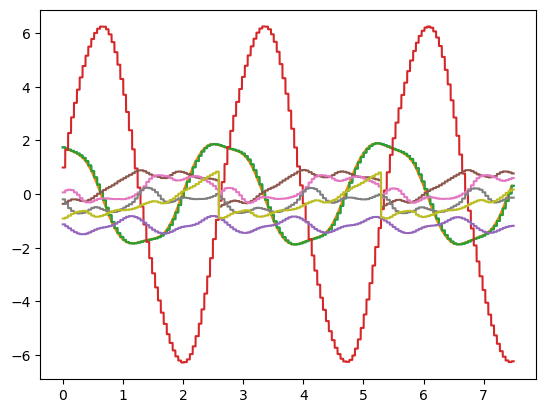

In [7]:
plt.plot(t, Z_data_mocap[:,0], label='x')
# add 0.2 gaussian noise to mocap measurements
# Z_data_mocap[:,0:3] += np.random.computed(0, 0.2, Z_data_mocap[:,0:3].shape)
plt.plot(t[opti_updates], Z_data_mocap[opti_updates,0], label='x')


plt.plot(t, Z_data_mocap[:,0], label='x')
plt.plot(t, Z_data_mocap[:,1], label='y')
plt.plot(t, Z_data_mocap[:,2], label='z')
plt.plot(t, Z_data_mocap[:,3], label='qw')
plt.plot(t, Z_data_mocap[:,4], label='qx')
plt.plot(t, Z_data_mocap[:,5], label='qy')
plt.plot(t, Z_data_mocap[:,6], label='qz')

In [106]:
# INITIALIZE EKF
# initial state
lenX = 16
X_init = np.zeros(lenX)
X_init[:3] = Z_data_mocap[0,:3]  # Position initialization (unchanged)

# Initialize velocities using data['ekf_vx'], data['ekf_vy'], and data['ekf_vz']
X_init[3] = data['ekf_vx'][0]
X_init[4] = data['ekf_vy'][0]
X_init[5] = data['ekf_vz'][0]

# Quaternion initialization (unchanged)
a = -72. * np.pi / 180.
X_init[6] = np.cos(0.5*a)
X_init[7] = 0.0
X_init[8] = 0.0
X_init[9] = np.sin(0.5*a)
X_init[6:10] = Z_data_mocap[0,3:7]
# X_init[12:15] = [p_bias, q_bias, r_bias]

# initial covariance
P_init = np.array([1.]*lenX)
#P_init[9] = 10. # initial heading covarinace
P_init[-6:-3] = 1e-2 # set accel bias covariance
P_init[-3:] = 0#1e-2 # set gyro bias covariance. 
# P_init[-3:] *= (ekf_use_quat.value) # do not estimate bias if no heading measurement
# print(P_init)

# process noise covariance
# Q_diag = np.array([0.5, 0.5, 0.5, 0.01, 0.01, 0.01, 1e-5, 1e-5, 1e-5, 0, 0, 0])
Q_diag = np.array([0.5, 0.5, 0.5, 0.001, 0.001, 0.001, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5])
Q_diag[-3:] *= (ekf_use_quat.value)

# measurement noise covariance MOCAP
R_diag_mocap = np.array([0.5, 0.5, 0.5, .0005, .0005, .0005, .0005])
# measurement noise covariance VBODY
R_diag_vbody = np.array([100000., 100000.])

lib.ekf_set_Q((ctypes.c_float*len(Q_diag))(*Q_diag))
lib.ekf_set_R_mocap((ctypes.c_float*len(R_diag_mocap))(*R_diag_mocap))
lib.ekf_set_R_vbody((ctypes.c_float*len(R_diag_vbody))(*R_diag_vbody))
lib.ekf_set_X((ctypes.c_float*len(X_init))(*X_init))
lib.ekf_set_P_diag((ctypes.c_float*len(P_init))(*P_init))

# test ekf_get_state
x = lib.ekf_get_X()
x = np.array([x[i] for i in range(lenX)])
print(x)

# RUN EKF
X_ekf = [X_init]
P_ekf = [np.array([1.])*int(lenX*(lenX+1)/2)]

X_sampled = []
Dx_list = [0]
Dy_list = [0]
Dz_list = [0]
X_delayed = []
X_shift =[]
m_idx =[]

# start with N mocap updates to converge more
# ekf_use_quat.value = True
# N = 100
# for i in range(N):
#     # update
#     lib.ekf_update_mocap(
#         (ctypes.c_float*len(Z_data_mocap[0]))(*Z_data_mocap[0])
#     )
ekf_use_quat.value = False

for i in range(1, len(t)):
    # PREDICT 
    U = np.zeros_like(U_data[i])

    # COMPUTE DRAG MODEL
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(lenX)])
    x,y,z,vxw,vyw,vzw,qw,qx,qy,qz = x[:10]
    # get body velocity from world velocity v_body = q_world_to_body * v_world * q_world_to_body_conj
    quat_inv = np.array([qw,-qx,-qy,-qz])
    v_world = np.array([vxw,vyw,vzw])
    v_body = quadRotate(quat_inv, v_world)
    
    # Dx = -4.41e-05*v_body[0]*(omega0[i] + omega1[i] + omega2[i] + omega3[i])
    # Dy = -5.64e-05*v_body[1]*(omega0[i] + omega1[i] + omega2[i] + omega3[i])
    Dx = k_x*v_body[0] * (omega0[i] + omega1[i] + omega2[i] + omega3[i]) #- 0.03*v_body[0]**2
    Dy = k_y*v_body[1] * (omega0[i] + omega1[i] + omega2[i] + omega3[i]) #- 0.01*v_body[1]**2
    Dz = k_omega * (omega0[i]**2 + omega1[i]**2 + omega2[i]**2 + omega3[i]**2) + k_z*v_body[2] * (omega0[i] + omega1[i]+ omega2[i] + omega3[i])  + k_h * (v_body[0]**2 + v_body[1]**2)

    #Dx = -4.20
    #Dy = 4.20
    #Dz = 2
    # append Dx, Dy, Dz to the list
    Dx_list.append(Dx)
    Dy_list.append(Dy)
    Dz_list.append(Dz)

    # print("wubdub")
    # print(Dz)
    # print(U_data[i,2:])
    # print("wubdub")
    # print(k_x, k_y)
    # print(omega0, omega1, omega2, omega3)
    # print(omega0 + omega1 + omega2 + omega3)
    # print(v_body[0], v_body[1])
    # print(Dx, Dy)
    # 
    alpha = 1.0
    U[0] = (1-alpha)*U_data[i,0] + alpha*Dx
    U[1] = (1-alpha)*U_data[i,1] + alpha*Dy
    U[2] = (1-alpha)*U_data[i,2] + alpha*Dz

    # put vz = 0
    #U[2] = 0
    # assume for now that U[2] is equal to the ground truth 
    #U[2] = U_data[i,2]
    U[3] = U_data[i,3]
    U[4] = U_data[i,4]
    U[5] = U_data[i,5]


    # print("wubdub")
    # print(U[2])
    # print(U_data[i,2])
    
    
    lib.ekf_predict(
        (ctypes.c_float*len(U))(*U),
        ctypes.c_float(t[i]-t[i-1])
    )
    # UPDATE MOCAP
    # only update when there is a new measurement
    # if np.any(Z_data_mocap[i]-Z_data_mocap[i-1] != 0):
    # if i in opti_updates:
    #     m_idx.append(i)
    #     # update
    #     Z = Z_data_mocap[i].copy()
    #     if ekf_use_quat.value == False:
    #         Z[3:] = 0
    #     lib.ekf_update_mocap(
    #         (ctypes.c_float*len(Z_data_mocap[i]))(*Z_data_mocap[i])
    #     )
        
    # UPDATE VBODY
    # only update when there is a new measurement
    # if np.any(Z_data_vbody[i]-Z_data_vbody[i-1] != 0):
    #     # update
    #     lib.ekf_update_vbody(
    #         (ctypes.c_float*len(Z_data_vbody[i]))(*Z_data_vbody[i])
    #     )
        
    # get state
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(lenX)])
    X_ekf.append(x)
    
    # get Pdiag
    P = lib.ekf_get_P()
    P = np.array([P[i] for i in range(int(lenX*(lenX+1)/2))])
    P_ekf.append(P)
    #print(P[[int(i*(i+1)/2 + i) for i in range(13,16)]])

X_ekf_normal = np.array(X_ekf)

Dx_list = np.array(Dx_list)
Dy_list = np.array(Dy_list)
Dz_list = np.array(Dz_list)




print(Dx_list.shape)
print(Dy_list.shape)
print(Dz_list.shape)
print(data['ax'].shape)

print(Dz_list)





[-1.19299996  6.16499996 -1.06099999 -0.88999999 -0.80000001  0.01
  0.31315368  0.02953119 -0.10139043 -0.94376767  0.          0.
  0.          0.          0.          0.        ]
(11080,)
(11080,)
(11080,)
(11080,)
[  0.         -10.19037277 -10.19798242 ...  -9.43145996  -9.4288655
  -9.42721796]


In [110]:
# plot trajectory
%matplotlib
X_ekf = np.array(X_ekf)
# Pdiag_ekf = np.array(Pdiag_ekf)

plot_velocity = True 
plot_accelerations = True
plot_rpms = True
plot_attitude = False
plot_biases = False
plot_quaternions = False

# 5x3 subplots
fig, axs = plt.subplots(7, 3, figsize=(20,7/5*20), tight_layout=True, sharex=True)
axs = axs.flatten()

# position
axs[0].plot(t, X_ekf_normal[:,0], label='x ekf computed')
axs[0].plot(t, data['ekf_x'], label='x ekf gt')
axs[0].plot(t, data['x_opti'], label='x opti')
axs[0].legend()
axs[0].set_xlabel('Time (s)')

axs[1].plot(t, X_ekf_normal[:,1], label='y ekf computed')
axs[1].plot(t, data['ekf_y'], label='y ekf gt')
axs[1].plot(t, data['y_opti'], label='y opti')
axs[1].legend()
axs[1].set_xlabel('Time (s)')

axs[2].plot(t, X_ekf_normal[:,2], label='z ekf computed')
axs[2].plot(t, data['ekf_z'], label='z ekf gt')
axs[2].plot(t, data['z_opti'], label='z opti')
axs[2].legend()
axs[2].set_xlabel('Time (s)')
x = -4.20
    #
# velocity
if plot_velocity:
    axs[3].plot(t, X_ekf_normal[:,3], label='vx ekf computed')
    axs[3].plot(t, data['ekf_vx'], label='vx ekf gt')
    axs[3].legend()
    axs[3].set_xlabel('Time (s)')

    axs[4].plot(t, X_ekf_normal[:,4], label='vy ekf computed')
    axs[4].plot(t, data['ekf_vy'], label='vy ekf gt')
    axs[4].legend()
    axs[4].set_xlabel('Time (s)')

    axs[5].plot(t, X_ekf_normal[:,5], label='vz ekf computed')
    axs[5].plot(t, data['ekf_vz'], label='vz ekf gt')
    axs[5].legend()
    axs[5].set_xlabel('Time (s)')

    # also plot body velocities below
    axs[6].plot(t, data['vbx'], label='vx body ekf computed')
    axs[7].plot(t, data['vby'], label='vy body ekf computed')
    axs[8].plot(t, data['vbz'], label='vz body ekf computed')
    axs[6].legend()
    axs[7].legend()
    axs[8].legend()
    axs[6].set_xlabel('Time (s)')
    axs[7].set_xlabel('Time (s)')
    axs[8].set_xlabel('Time (s)')

plot_accelerations = True

if plot_accelerations:
    axs[9].plot(t, Dx_list, label='Dx')
    axs[9].plot(t, data['ax'], label='ax ekf gt')
    axs[9].plot(t, np.array(Dx_list) - data['ax'], label='Dx - ax error')
    axs[9].legend()
    axs[9].set_xlabel('Time (s)')

    axs[10].plot(t, Dy_list, label='Dy')
    axs[10].plot(t, data['ay'], label='ay ekf gt')
    axs[10].plot(t, np.array(Dy_list) - data['ay'], label='Dy - ay error')
    axs[10].legend()
    axs[10].set_xlabel('Time (s)')

    axs[11].plot(t, Dz_list, label='Dz')
    axs[11].plot(t, data['az'], label='az ekf gt')
    axs[11].plot(t, np.array(Dz_list) - data['az'], label='Dz - az error')
    axs[11].legend()
    axs[11].set_xlabel('Time (s)')

if plot_rpms:
    axs[12].plot(t, omega0, label='omega0')
    axs[12].plot(t, omega1, label='omega1')
    axs[12].plot(t, omega2, label='omega2')
    axs[12].plot(t, omega3, label='omega3')
    axs[12].legend()
    axs[12].set_xlabel('Time (s)')



# attitude
if plot_attitude:
    rad_to_deg = 180/np.pi
    from scipy.spatial.transform import Rotation
    eulers = Rotation.from_quat(X_ekf_normal[:, [7, 8, 9, 6]]).as_euler('xyz', degrees=False)

    axs[6].plot(t, rad_to_deg*eulers[:,0], label='phi ekf computed')
    axs[6].plot(t, rad_to_deg*data['ekf_phi'], label='phi ekf gt')
    axs[6].plot(t, rad_to_deg*data['phi_opti'], label='phi opti')
    axs[6].legend()
    axs[6].set_xlabel('Time (s)')

    axs[7].plot(t, rad_to_deg*eulers[:,1], label='theta ekf computed')
    axs[7].plot(t, rad_to_deg*data['ekf_theta'], label='theta ekf gt')
    axs[7].plot(t, rad_to_deg*data['theta_opti'], label='theta opti')
    axs[7].legend()
    axs[7].set_xlabel('Time (s)')

    axs[8].plot(t, rad_to_deg*eulers[:,2], label='psi ekf computed')
    axs[8].plot(t, rad_to_deg*data['ekf_psi'], label='psi ekf gt')
    axs[8].plot(t, rad_to_deg*data['psi_opti'], label='psi opti')
    axs[8].legend()
    axs[8].set_xlabel('Time (s)')

# biases
if plot_biases:
    axs[9].plot(t, X_ekf_normal[:,10], label='lx ekf computed')
    axs[9].plot(t, data['ekf_acc_b_x'], label='lx ekf gt')
    axs[9].set_ylim([-0.25, 0.25])
    axs[9].legend()
    axs[9].set_xlabel('Time (s)')

    axs[10].plot(t, X_ekf_normal[:,11], label='ly ekf computed')
    axs[10].plot(t, data['ekf_acc_b_y'], label='ly ekf gt')
    axs[10].set_ylim([-0.25, 0.25])
    axs[10].legend()
    axs[10].set_xlabel('Time (s)')

    axs[11].plot(t, X_ekf_normal[:,12], label='lz ekf computed')
    axs[11].plot(t, data['ekf_acc_b_z'], label='lz ekf gt')
    axs[11].set_ylim([-0.25, 0.25])
    axs[11].legend()
    axs[11].set_xlabel('Time (s)')

    axs[12].plot(t, rad_to_deg*X_ekf_normal[:,13], label='lp ekf computed')
    axs[12].plot(t, rad_to_deg*data['ekf_gyro_b_x'], label='lp ekf gt')
    axs[12].set_ylim([-0.1, 0.1])
    axs[12].legend()
    axs[12].set_xlabel('Time (s)')

    axs[13].plot(t, rad_to_deg*X_ekf_normal[:,14], label='lq ekf computed')
    axs[13].plot(t, rad_to_deg*data['ekf_gyro_b_y'], label='lq ekf gt')
    axs[13].set_ylim([-0.1, 0.1])
    axs[13].legend()
    axs[13].set_xlabel('Time (s)')

    axs[14].plot(t, rad_to_deg*X_ekf_normal[:,15], label='lr ekf computed')
    axs[14].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='lr ekf gt')
    axs[14].set_ylim([-0.1, 0.1])
    axs[14].legend()
    axs[14].set_xlabel('Time (s)')

# quaternions
if plot_quaternions:
    axs[15].plot(t, X_ekf_normal[:,6], label='qw ekf computed')
    axs[15].plot(t, data['qw_opti'], label='qw opti')
    axs[15].legend()
    axs[15].set_xlabel('Time (s)')

    axs[18].plot(t, X_ekf_normal[:,7], label='qx ekf computed')
    axs[18].plot(t, data['qx_opti'], label='qx opti')
    axs[18].legend()
    axs[18].set_xlabel('Time (s)')

    axs[19].plot(t, X_ekf_normal[:,8], label='qy ekf computed')
    axs[19].plot(t, data['qy_opti'], label='qy opti')
    axs[19].legend()
    axs[19].set_xlabel('Time (s)')

    axs[20].plot(t, X_ekf_normal[:,9], label='qz ekf computed')
    axs[20].plot(t, data['qz_opti'], label='qz opti')
    axs[20].legend()
    axs[20].set_xlabel('Time (s)')

# Remove empty subplots
for ax in axs:
    if not ax.lines:
        fig.delaxes(ax)

plt.show()

Using matplotlib backend: TkAgg


In [111]:
pos_ekf = X_ekf[:,0:3]
pos_opti = np.array([data['x_opti'], data['y_opti'], data['z_opti']])
data_2 = data.copy()
data_2['x'] = X_ekf[:,0]
data_2['y'] = X_ekf[:,1]
data_2['z'] = X_ekf[:,2]

# gate_pos and gate_yaw
gate_pos = np.array([
    [1.5, -5., -1.5],
    [1.5,  5., -1.5],
    [0.0, 6.5, -1.5],
    [-1.5, 5., -1.5],
    [-1.5, -5., -1.5],
    [0.0, -6.5, -1.5]
])
gate_yaw = np.array([0, 0, 0.5, 1, 1, 1.5])*np.pi+np.pi/2
#animate_data_multiple2(data2, gate_pos=gate_pos, gate_yaw=gate_yaw)

# plot difference between ekf and optitrack
diff = pos_ekf - pos_opti.T
diff_norm = np.linalg.norm(diff, axis=1)
print(diff_norm)
plt.plot(t, diff_norm)

animate_data_multiple2(data_2, gate_pos=gate_pos, gate_yaw=gate_yaw)


[0.00000000e+00 2.37547071e-03 4.75209433e-03 ... 1.38901899e+01
 1.38953880e+01 1.39005925e+01]


In [63]:
# animate


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/erin/.local/lib/python3.10/site-packages/cv2/qt/plugins"
